In [1]:
import os
import sys
cwd = os.getcwd()
module_path = os.path.abspath(os.path.join('..'))
sys.path.insert(0, os.path.join(cwd, "../"))

import pickle
import torch
import importlib
import numpy as np
import pandas as pd
import copy

import src.bin.tensorify as tensorify
import src.utils.data_conversion_utils as conversions
import src.data_manager.student_life_var_binned_data_manager as data_manager
import src.bin.trainer as trainer
from sklearn.model_selection import train_test_split

from sklearn import metrics

from torch import nn
from src import definitions
from src.bin import validations
from src.bin import statistics
from src.bin import plotting
from src.utils.read_utils import read_pickle
from src.utils import student_utils
from src.data_manager import sub_sampler
from src.data_manager import cross_val
from src.data_manager import helper as data_manager_helper

from tabulate import tabulate 
import src.models.simple as simple_models
import src.models.gatis_mp as models

pd.set_option('max_rows', 10000)

%load_ext autoreload
%autoreload 2
feature_list = data_manager.FEATURE_LIST

##### Pickle ######
# data = read_pickle('../data/training_data/most_representative_6_hr_b_imputed_normalized_prev_stress_data.pkl')


Student ID couldn't be converted to Integer!


In [2]:
import torch.utils.data as torch_utils
from torch.utils.data import DataLoader
from tqdm import tqdm

In [3]:
data_path = module_path + "/data"
file_path = data_path + "/gatis.pkl"
data = pd.read_pickle(file_path)
display(data[:3])

,time,distance,displacement,distance_std,unique_tile_count,convex_hull_area,tile_change,cluster,entropy,start_term,end_term,mid_term,weekends,stress,student_id
11,2013-04-07,0.882327,0.322038,0.046489,1,59.677504,2,4,2.328591,1,0,0,1,2,24
2,2013-04-01,4.475847,0.748614,0.169167,1,639.564543,1,6,2.464626,1,0,0,0,0,7
0,2013-03-27,5.367546,0.932402,0.207269,1,2107.786910,0,4,2.571405,1,0,0,0,0,4


In [4]:
features_cols = ['distance', 'displacement', 'distance_std', 'unique_tile_count', 'convex_hull_area', 'tile_change', 
                 'cluster', 'entropy', 'start_term', 'end_term', 'mid_term', 'weekends']
label_col = ['stress']
features = data[features_cols]
labels   = data[label_col]
display(features[:3])
display(labels[:3])

data.isnull().values.any()

,distance,displacement,distance_std,unique_tile_count,convex_hull_area,tile_change,cluster,entropy,start_term,end_term,mid_term,weekends
11,0.882327,0.322038,0.046489,1,59.677504,2,4,2.328591,1,0,0,1
2,4.475847,0.748614,0.169167,1,639.564543,1,6,2.464626,1,0,0,0
0,5.367546,0.932402,0.207269,1,2107.786910,0,4,2.571405,1,0,0,0


,stress
11,2
2,0
0,0


False

In [5]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.10, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=1)
print('total=', len(features), 'train=',len(X_train), 'val=', len(X_val),'test=', len(X_test))


total= 636 train= 500 val= 72 test= 64


In [42]:
dropout = 0.85
learning_rate = 0.0001
momentum = 0.98
n_epochs = 80
batch_size=32

In [43]:
# train_loader = DataLoader([X_train.values, y_train.values] ,batch_size=32, shuffle=True)
# print(train_loader)
def pd_to_loader(X, Y, batch_size=32, shuffle=False):
    xt_train,yt_train = torch.Tensor(X.values), torch.LongTensor(Y.values)
    yt_train = yt_train.view(-1, )
    tensor_dataset_train = torch_utils.TensorDataset(xt_train, yt_train)
    loader = DataLoader(tensor_dataset_train, batch_size=batch_size, shuffle=shuffle)
    return loader
    
train_loader = pd_to_loader(X_train, y_train, batch_size=batch_size, shuffle=True)
val_loader   = pd_to_loader(X_val, y_val, batch_size=batch_size)
test_loader  = pd_to_loader(X_test, y_test, batch_size=batch_size)

def eval_network(loader, net, criterion, optimizer, training=False):
    running_loss = 0.0
    final_preds, final_labels = [], []
    if training:
        net.train()
    else:
        net.eval()
    for i, minibatch in enumerate(loader, 0):
        batch, labels = minibatch
        optimizer.zero_grad()
        logits = net(batch)
        preds = torch.argmax(logits, dim=1)
        final_preds += preds.numpy().tolist()
        final_labels += labels.numpy().tolist()
        loss = criterion(logits, labels)
        if training:
            loss.backward()
            optimizer.step()
        running_loss += loss.item()
#         print(running_loss)
    return running_loss, final_labels, final_preds

In [44]:
net = models.GatisNet()
print(net)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

GatisNet(
  (dense): Sequential(
    (0): Linear(in_features=12, out_features=57, bias=True)
    (1): Tanh()
    (2): Linear(in_features=57, out_features=35, bias=True)
    (3): Tanh()
    (4): Linear(in_features=35, out_features=35, bias=True)
    (5): Tanh()
    (6): Linear(in_features=35, out_features=3, bias=True)
    (7): Softmax()
  )
)


xxxxxxxxxxxxxx epoch: 0 xxxxxxxxxxxxxx


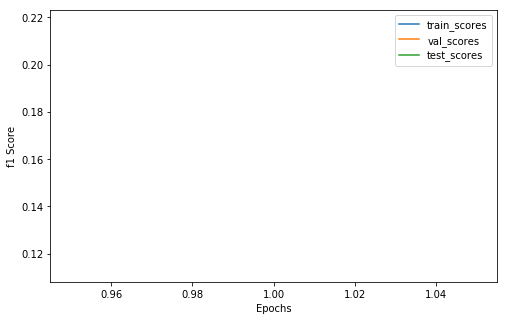

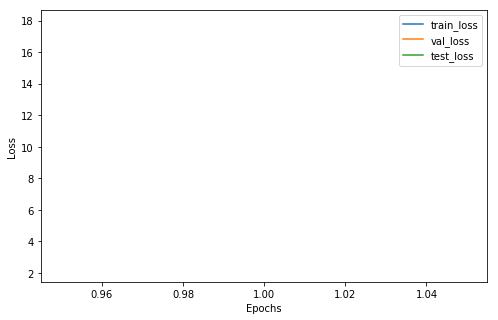

Cofusion Matrix For Val Set: 
-  -  --
0  0  14
0  3  41
0  0  14
-  -  --
xxxxxxxxxxxxxx epoch: 1 xxxxxxxxxxxxxx


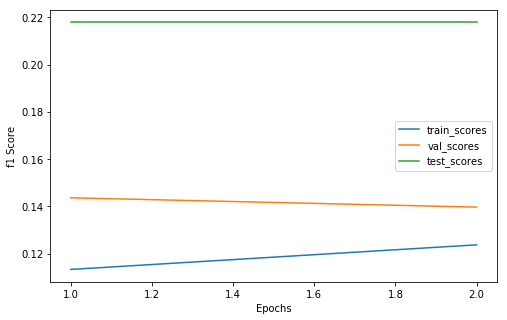

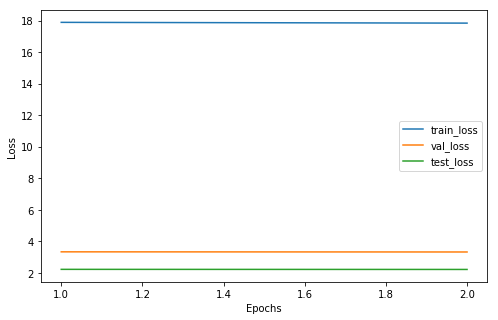

Cofusion Matrix For Val Set: 
-  -  --
0  0  14
0  3  41
1  0  13
-  -  --
xxxxxxxxxxxxxx epoch: 2 xxxxxxxxxxxxxx


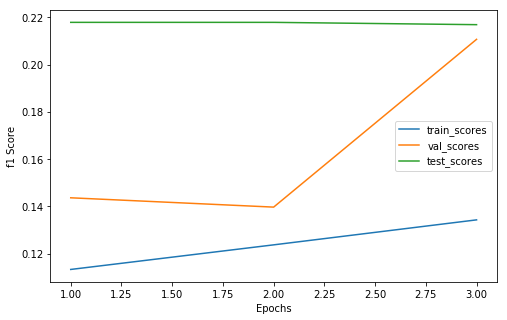

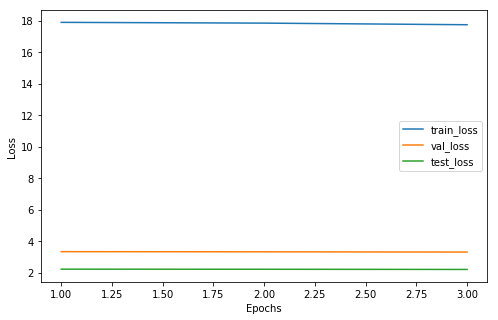

Cofusion Matrix For Val Set: 
-  -  --
0  0  14
0  6  38
1  0  13
-  -  --
xxxxxxxxxxxxxx epoch: 3 xxxxxxxxxxxxxx


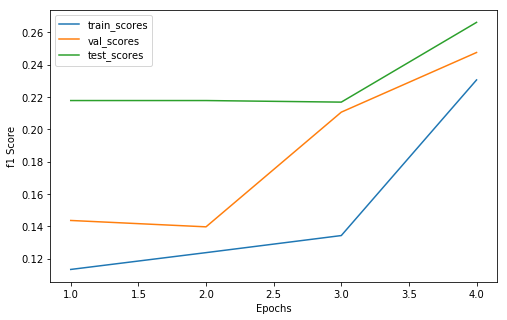

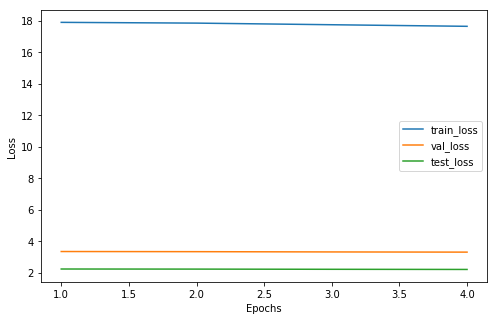

Cofusion Matrix For Val Set: 
-  -  --
0  1  13
0  8  36
0  1  13
-  -  --
xxxxxxxxxxxxxx epoch: 4 xxxxxxxxxxxxxx


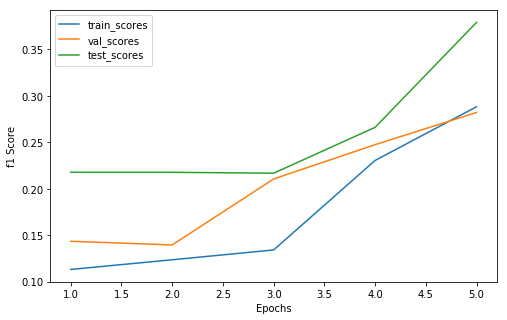

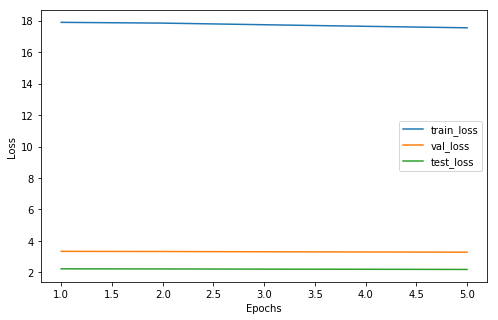

Cofusion Matrix For Val Set: 
-  --  --
0   3  11
0  12  32
0   5   9
-  --  --
xxxxxxxxxxxxxx epoch: 5 xxxxxxxxxxxxxx


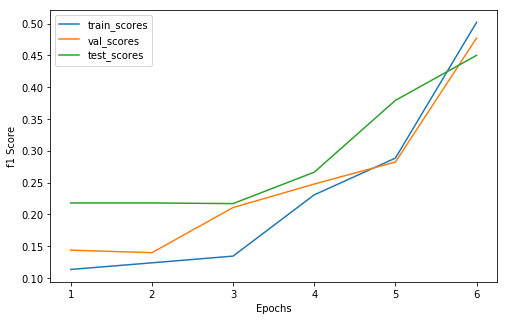

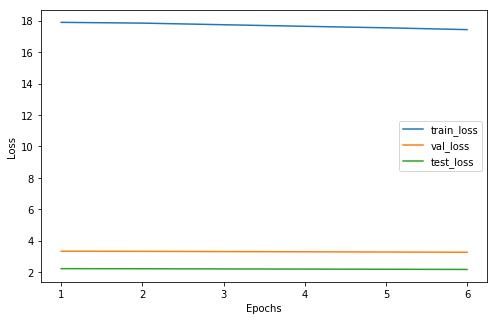

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  42  2
0  13  1
-  --  -
xxxxxxxxxxxxxx epoch: 6 xxxxxxxxxxxxxx


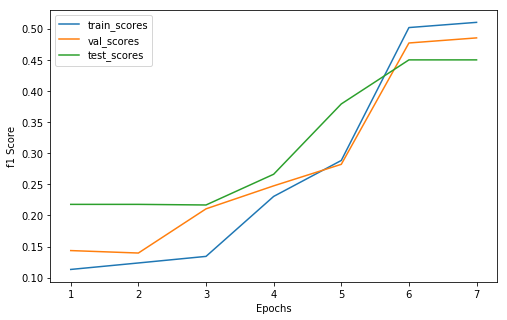

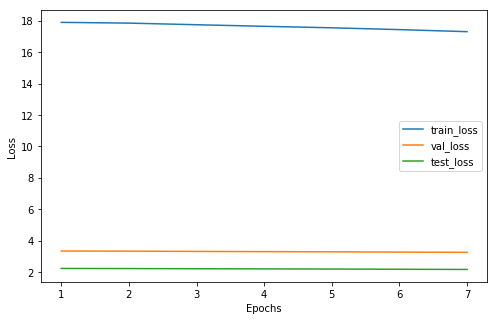

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  43  1
0  13  1
-  --  -
xxxxxxxxxxxxxx epoch: 7 xxxxxxxxxxxxxx


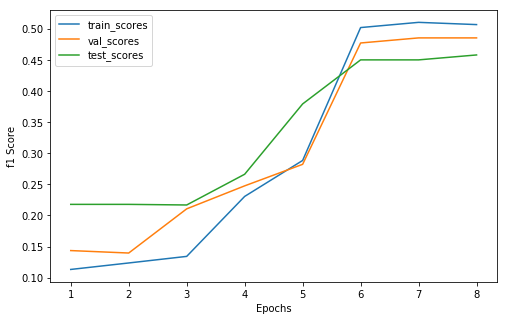

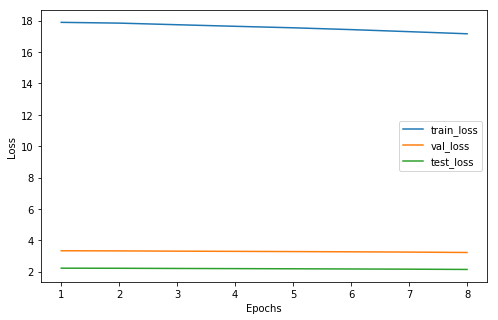

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  43  1
0  13  1
-  --  -
xxxxxxxxxxxxxx epoch: 8 xxxxxxxxxxxxxx


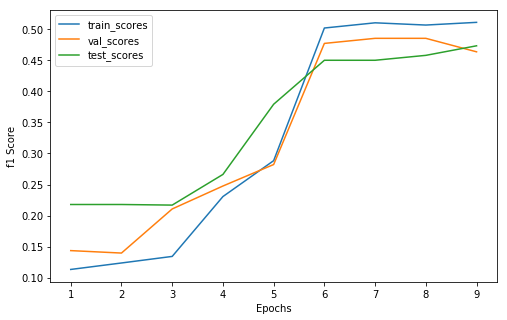

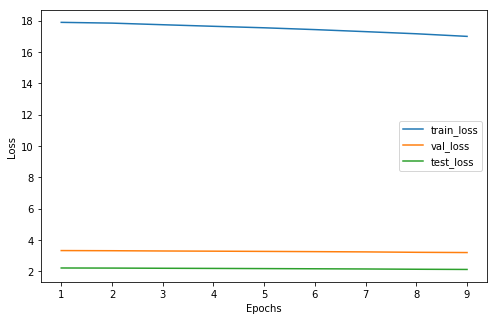

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 9 xxxxxxxxxxxxxx


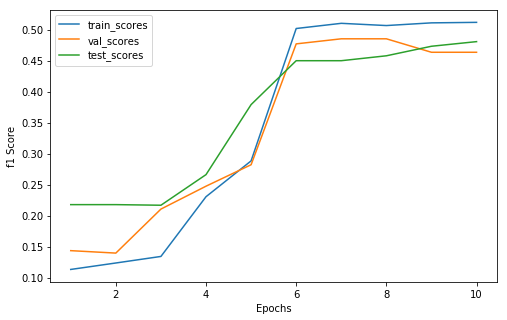

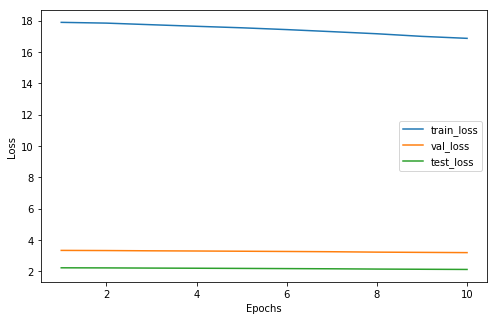

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 10 xxxxxxxxxxxxxx


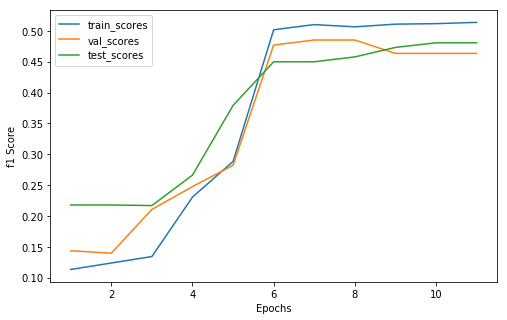

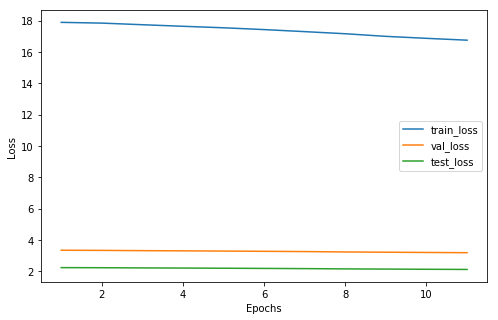

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 11 xxxxxxxxxxxxxx


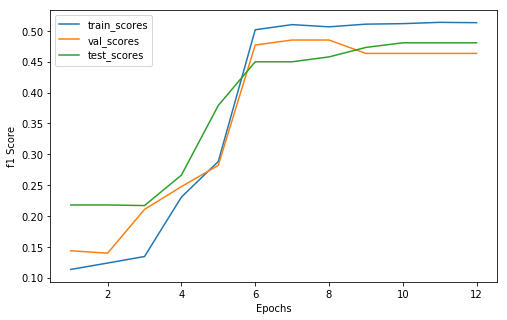

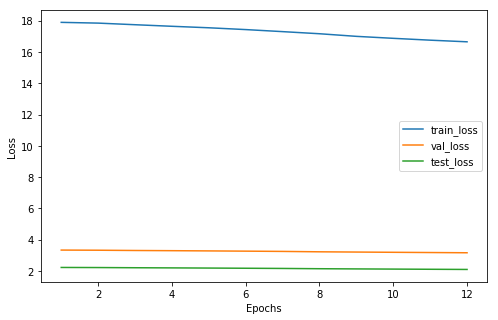

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 12 xxxxxxxxxxxxxx


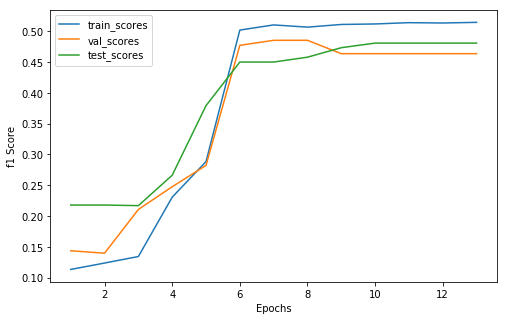

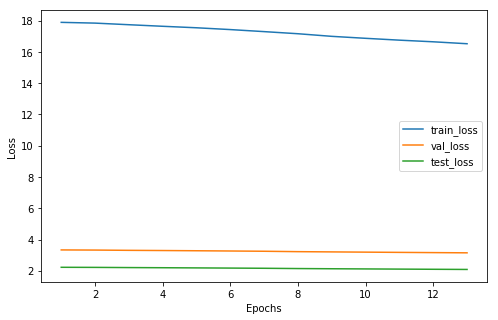

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 13 xxxxxxxxxxxxxx


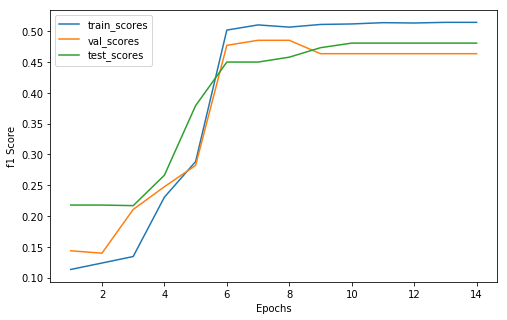

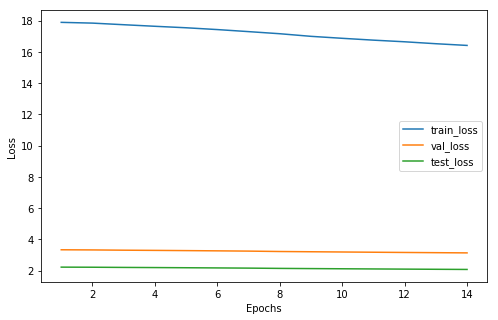

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 14 xxxxxxxxxxxxxx


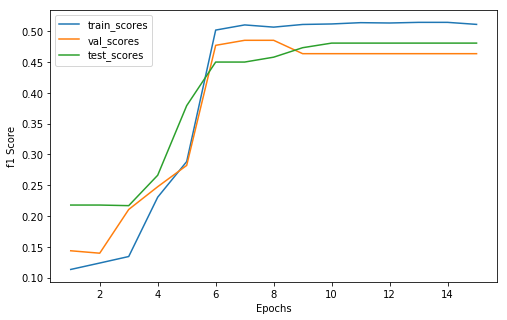

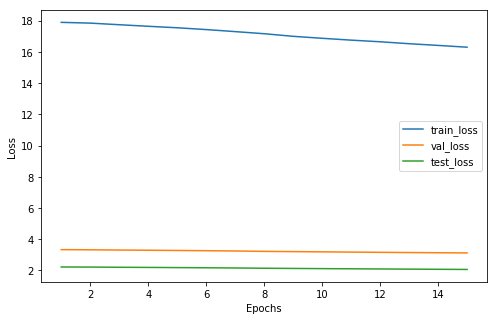

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 15 xxxxxxxxxxxxxx


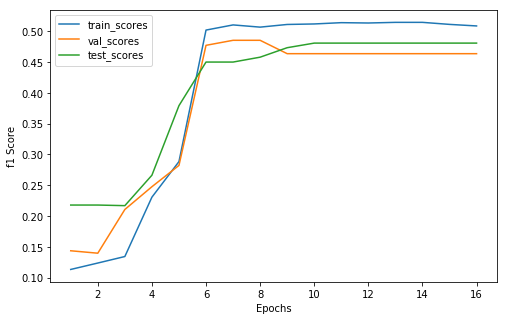

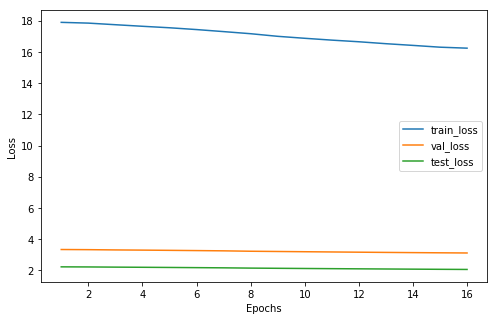

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 16 xxxxxxxxxxxxxx


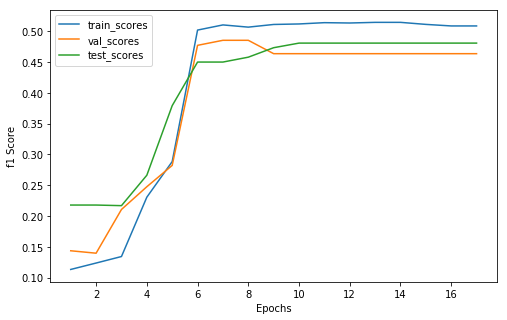

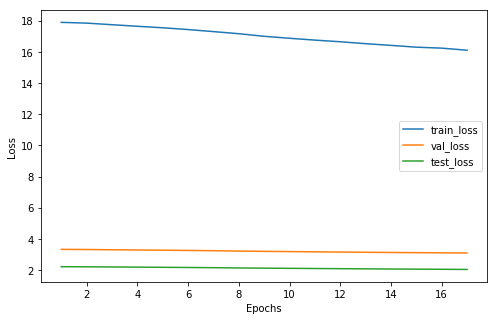

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 17 xxxxxxxxxxxxxx


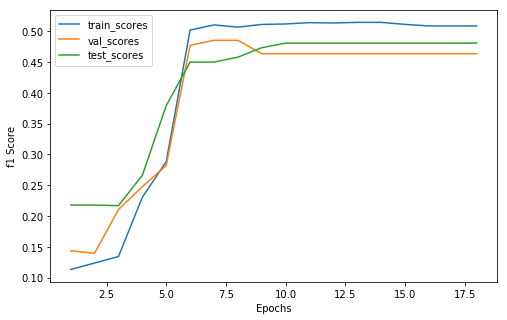

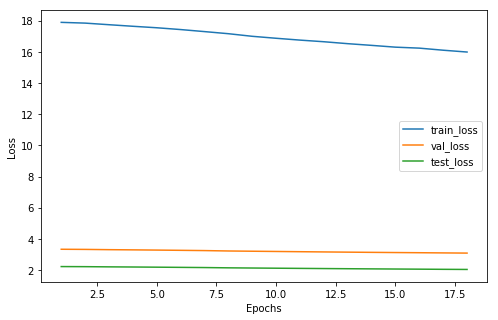

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 18 xxxxxxxxxxxxxx


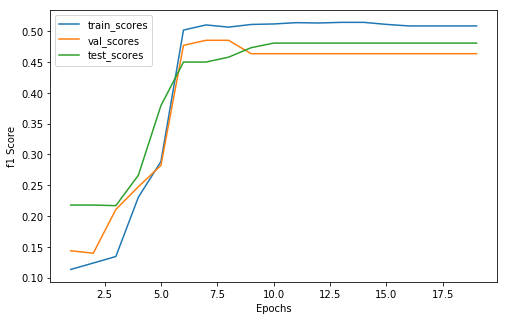

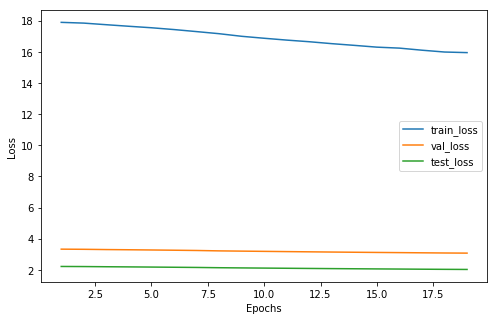

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 19 xxxxxxxxxxxxxx


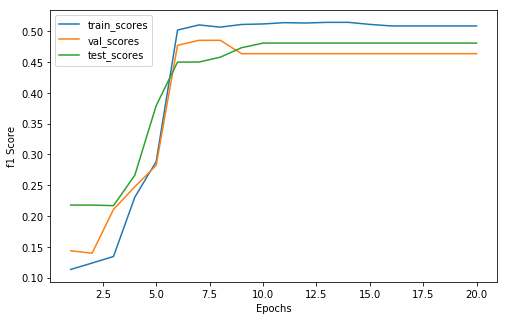

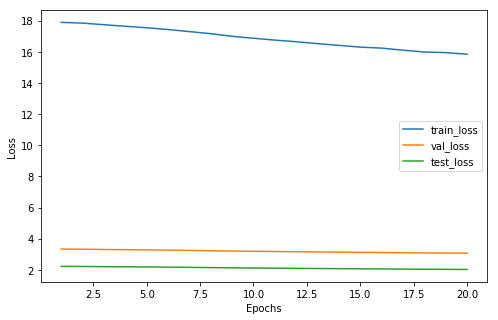

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 20 xxxxxxxxxxxxxx


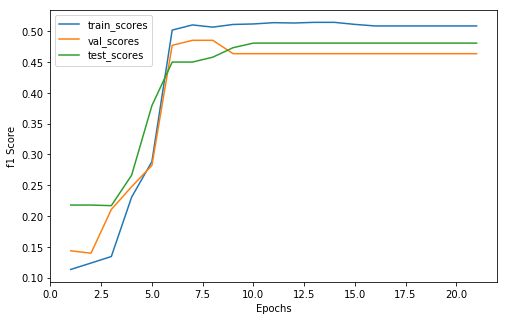

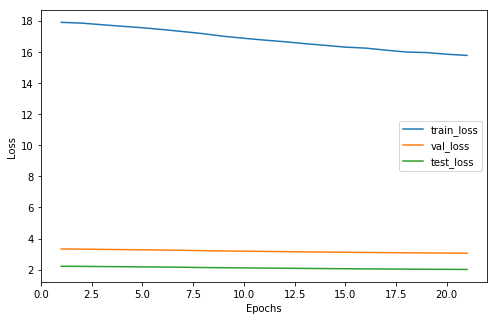

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 21 xxxxxxxxxxxxxx


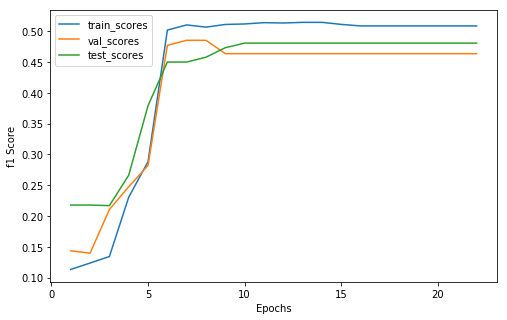

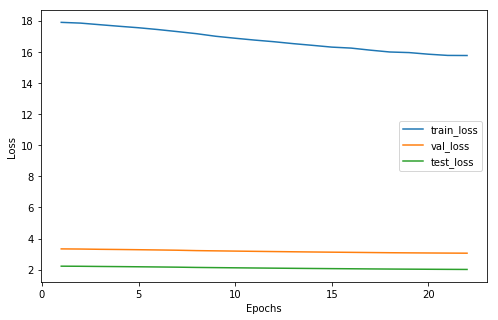

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 22 xxxxxxxxxxxxxx


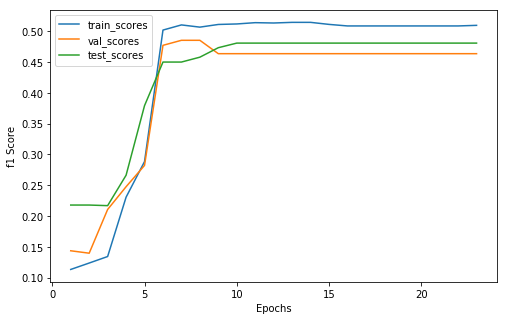

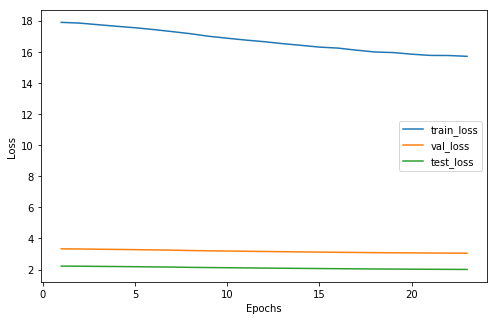

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 23 xxxxxxxxxxxxxx


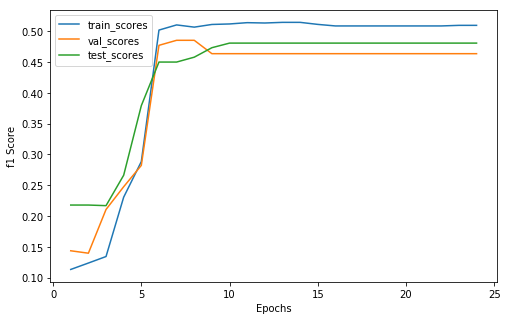

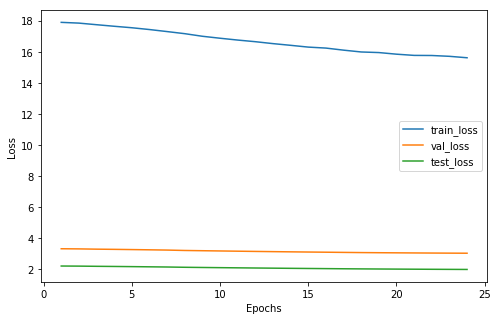

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 24 xxxxxxxxxxxxxx


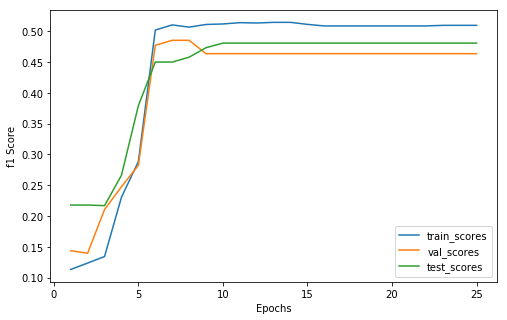

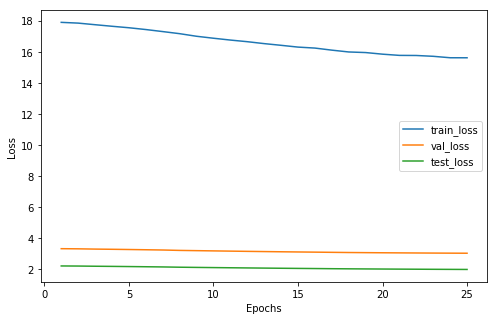

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 25 xxxxxxxxxxxxxx


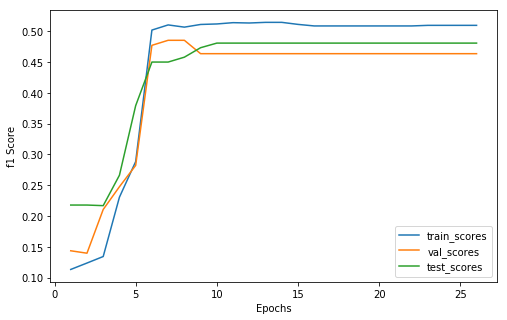

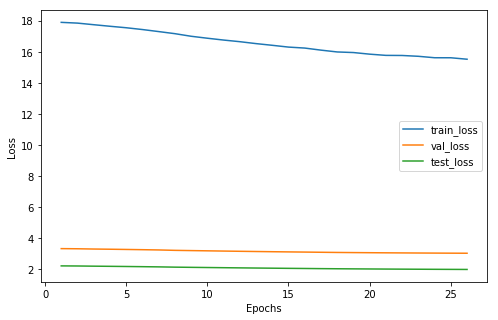

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 26 xxxxxxxxxxxxxx


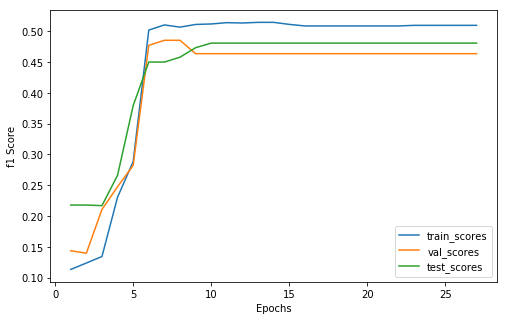

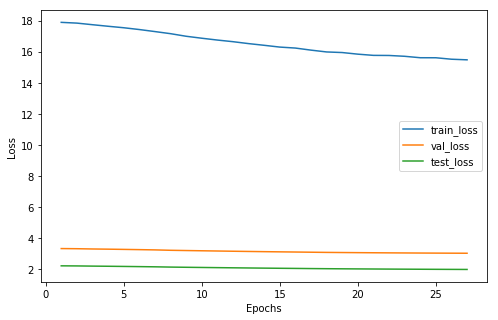

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 27 xxxxxxxxxxxxxx


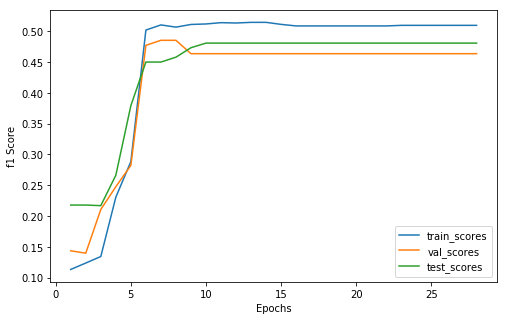

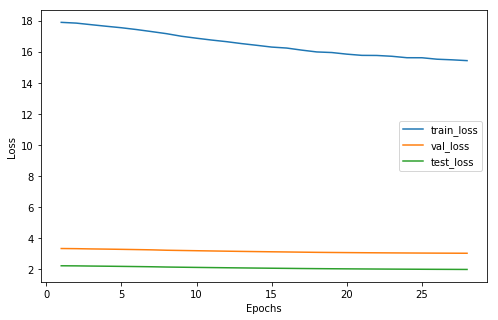

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 28 xxxxxxxxxxxxxx


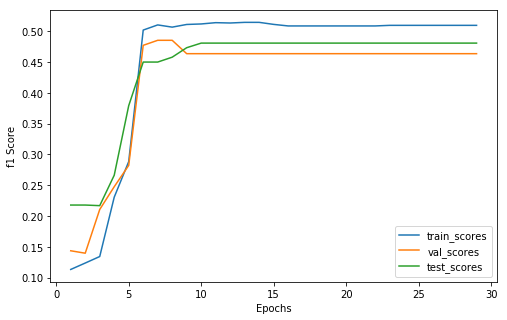

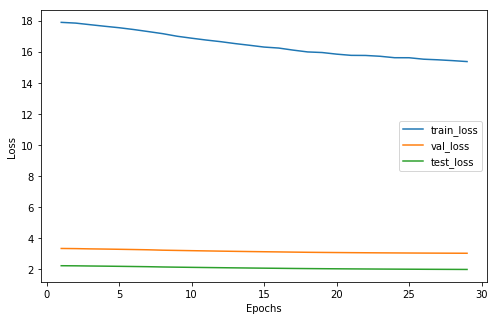

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 29 xxxxxxxxxxxxxx


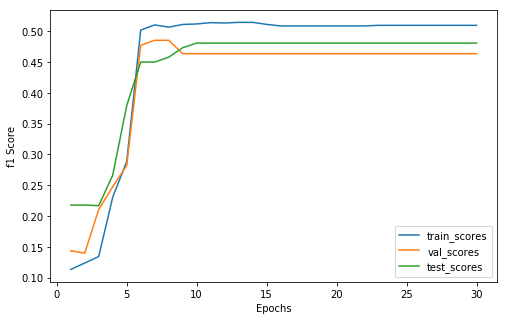

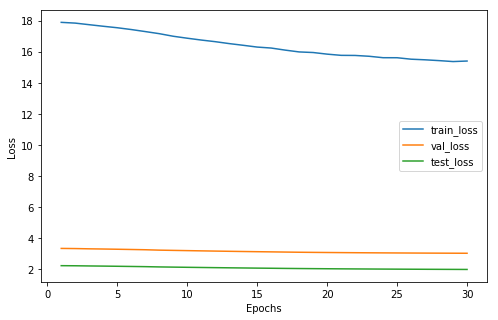

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 30 xxxxxxxxxxxxxx


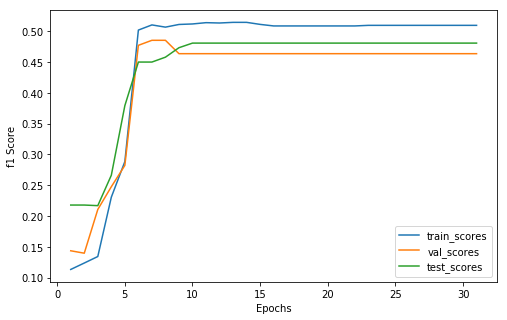

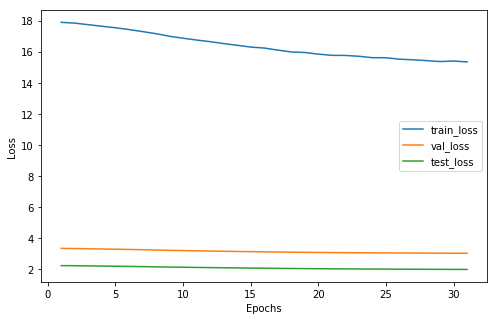

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 31 xxxxxxxxxxxxxx


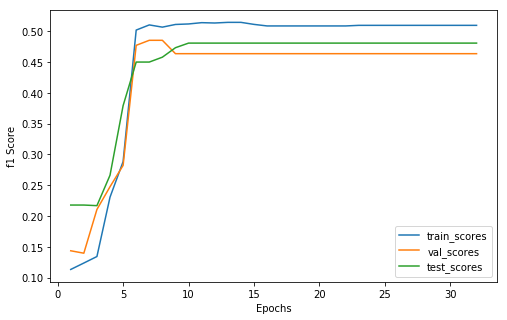

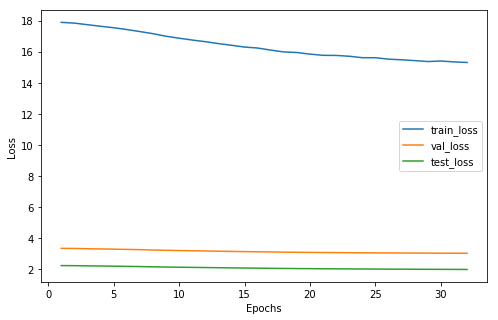

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 32 xxxxxxxxxxxxxx


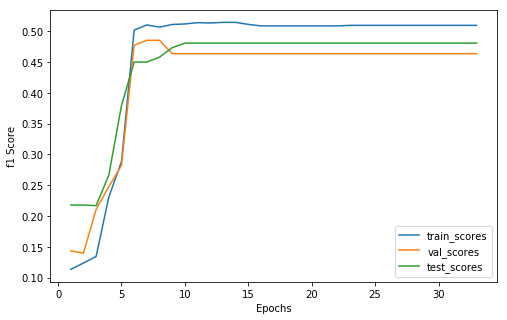

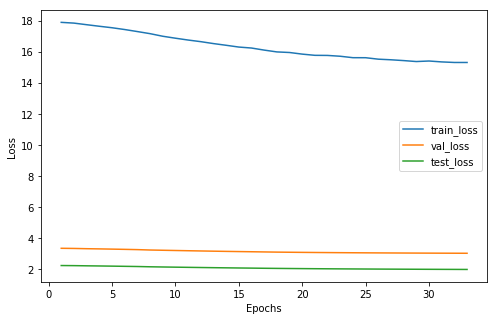

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 33 xxxxxxxxxxxxxx


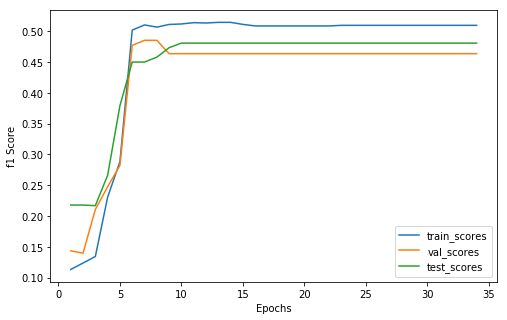

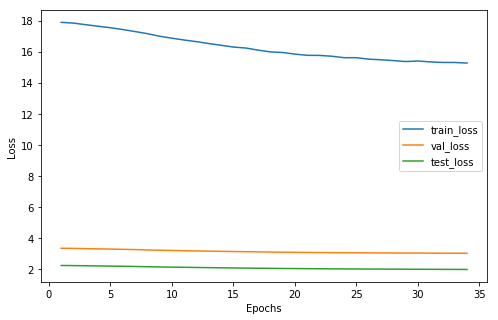

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 34 xxxxxxxxxxxxxx


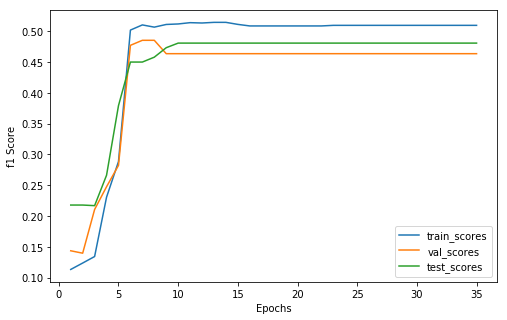

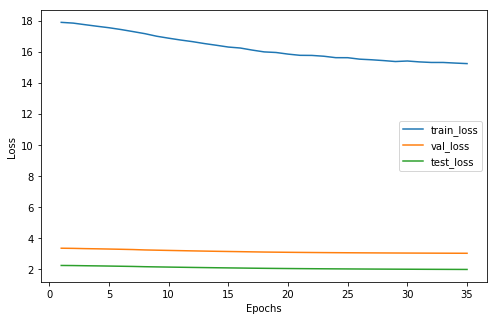

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 35 xxxxxxxxxxxxxx


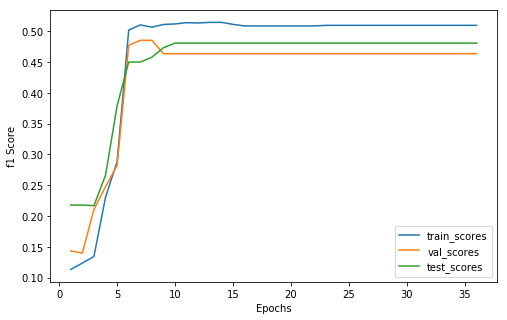

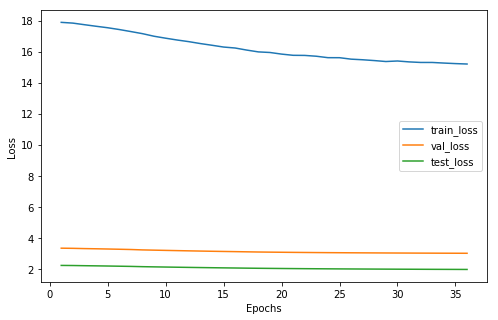

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 36 xxxxxxxxxxxxxx


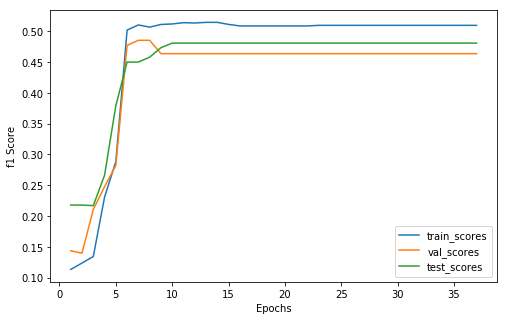

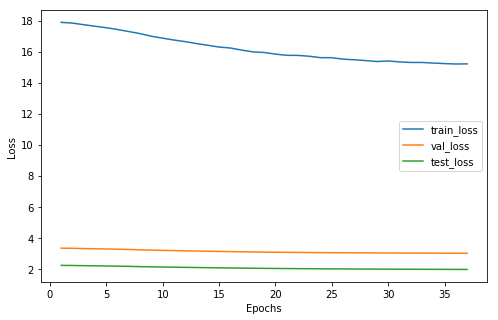

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 37 xxxxxxxxxxxxxx


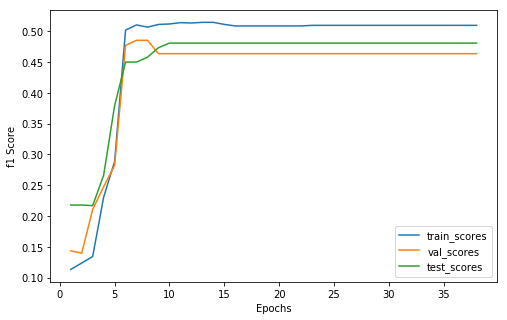

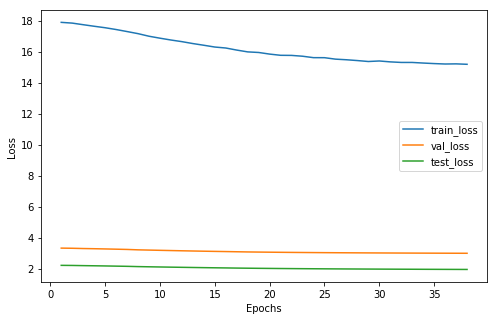

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 38 xxxxxxxxxxxxxx


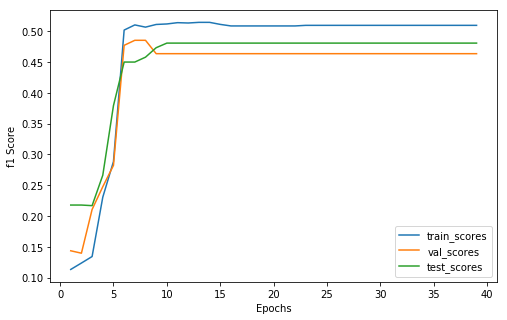

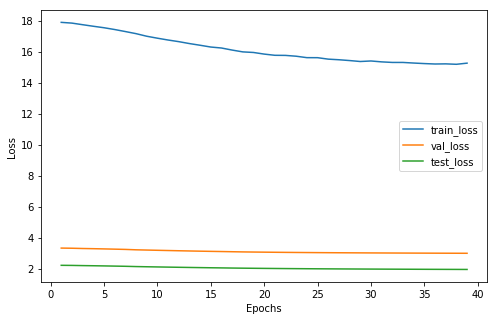

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 39 xxxxxxxxxxxxxx


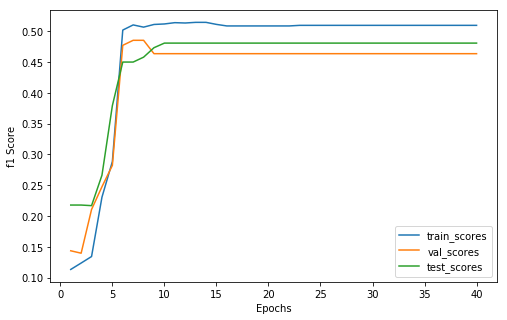

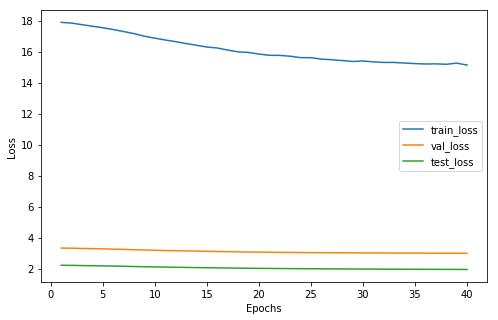

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 40 xxxxxxxxxxxxxx


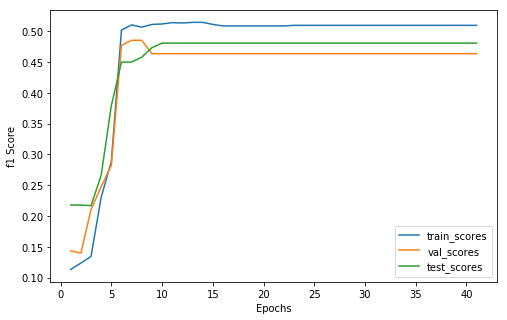

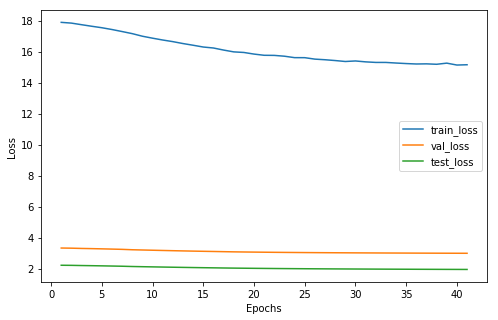

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 41 xxxxxxxxxxxxxx


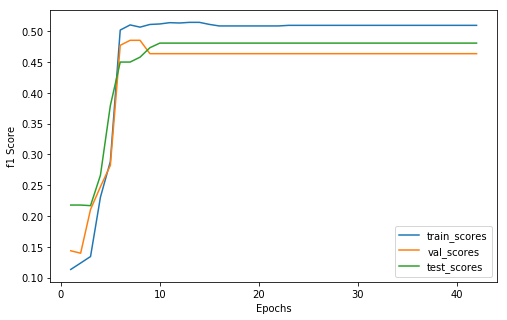

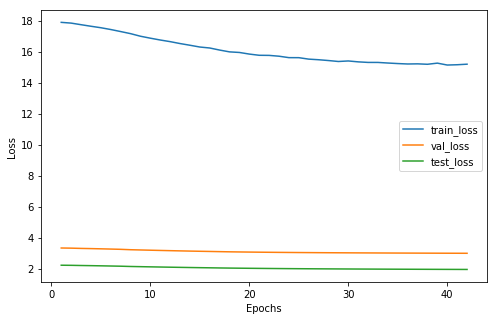

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 42 xxxxxxxxxxxxxx


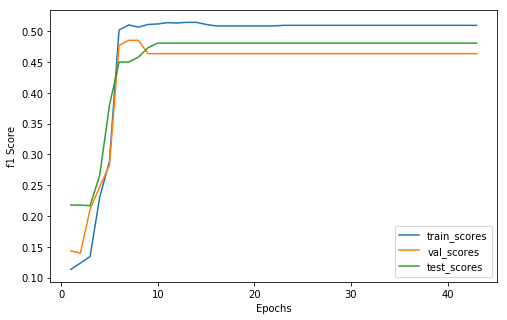

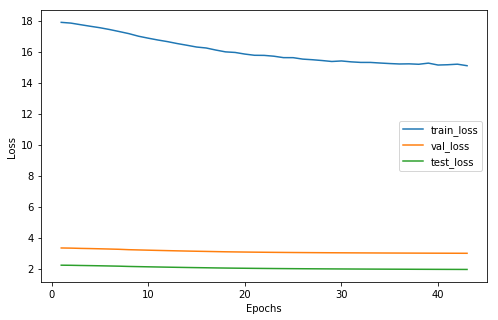

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 43 xxxxxxxxxxxxxx


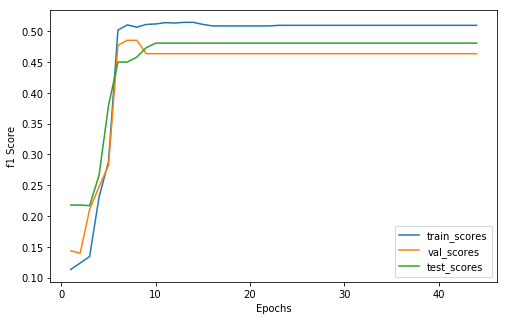

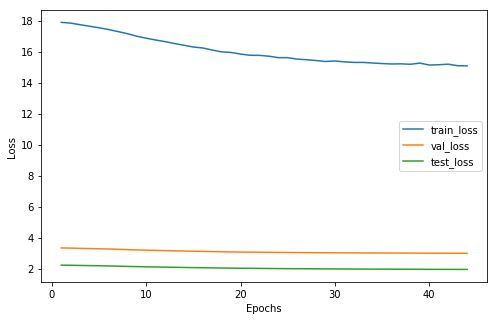

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 44 xxxxxxxxxxxxxx


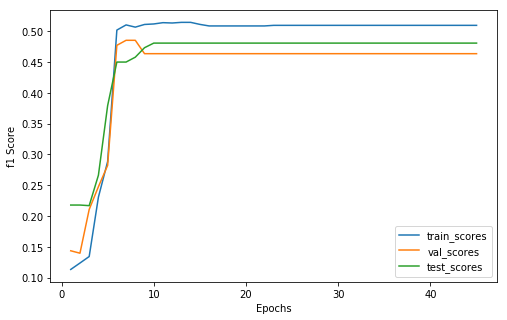

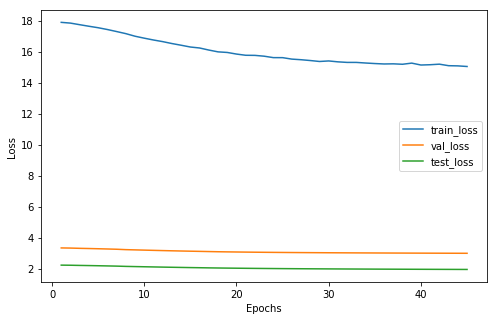

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 45 xxxxxxxxxxxxxx


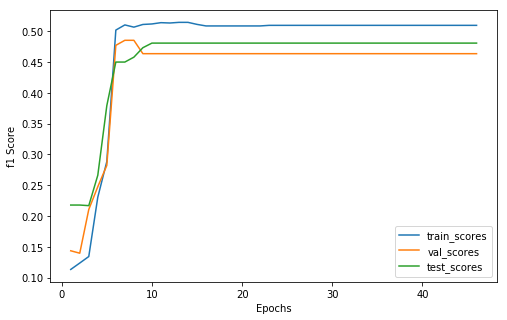

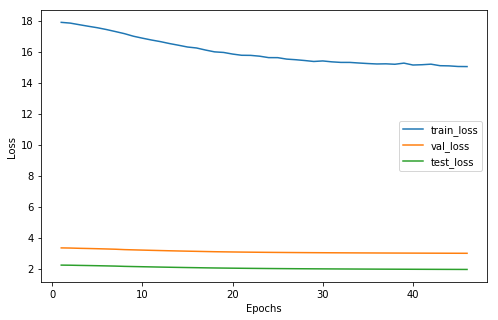

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 46 xxxxxxxxxxxxxx


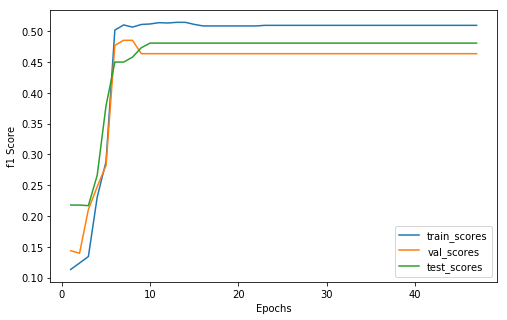

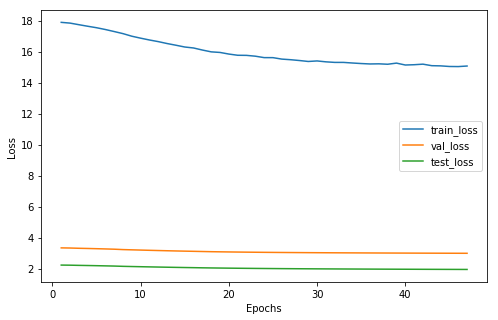

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 47 xxxxxxxxxxxxxx


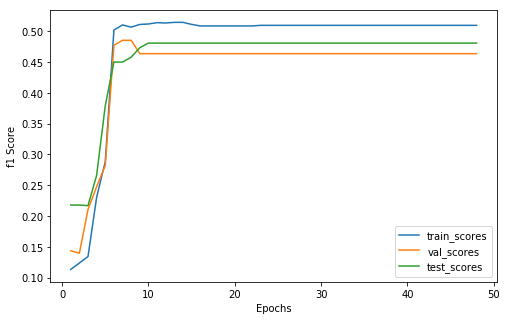

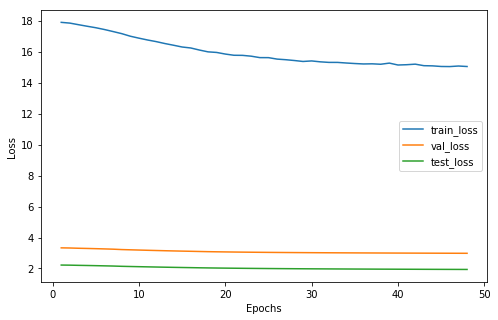

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 48 xxxxxxxxxxxxxx


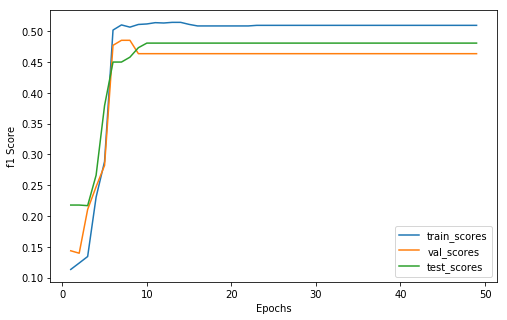

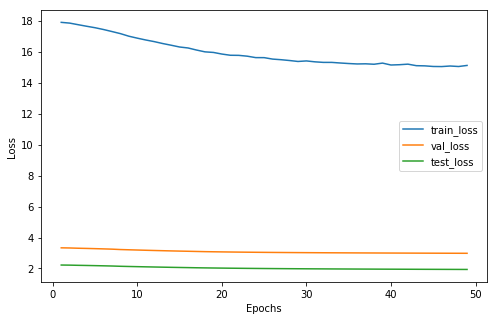

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 49 xxxxxxxxxxxxxx


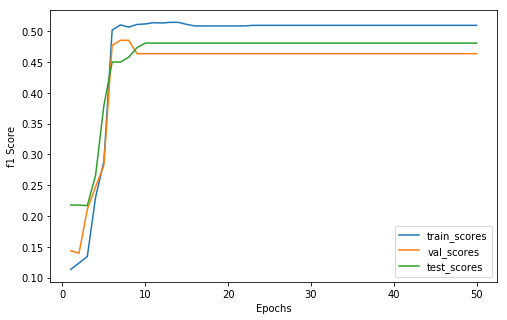

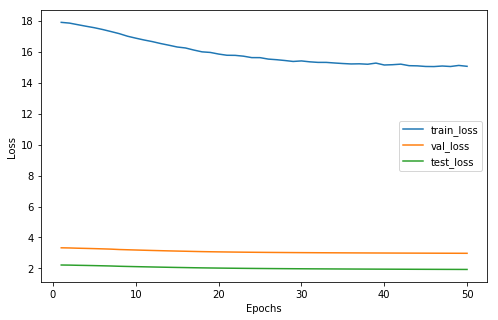

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 50 xxxxxxxxxxxxxx


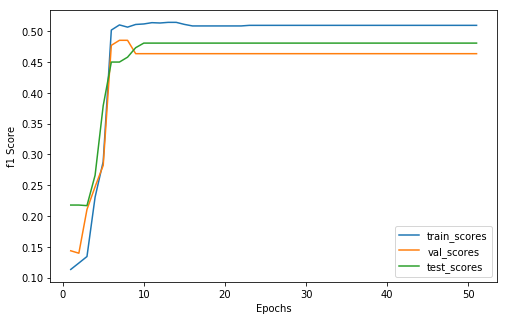

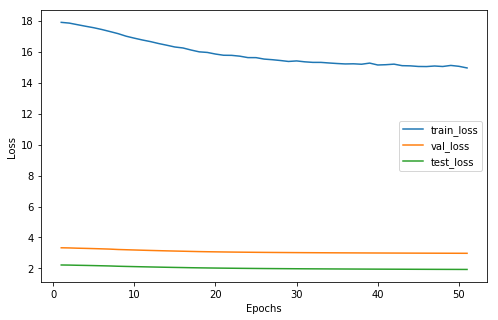

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 51 xxxxxxxxxxxxxx


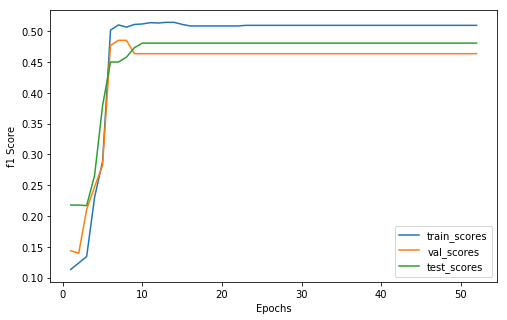

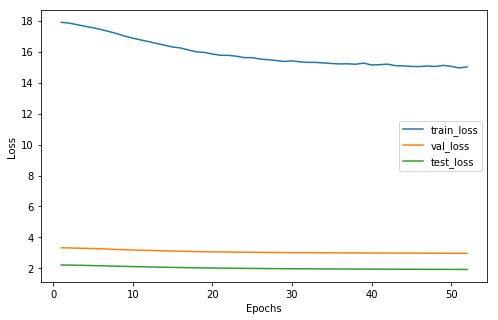

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 52 xxxxxxxxxxxxxx


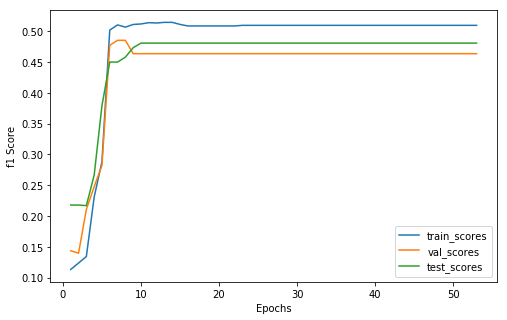

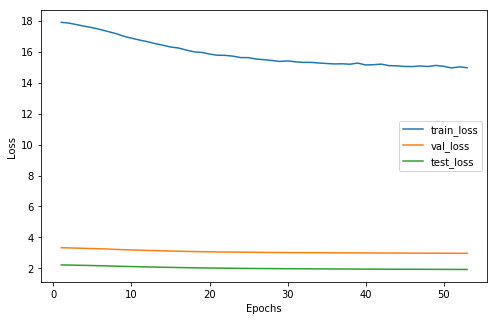

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 53 xxxxxxxxxxxxxx


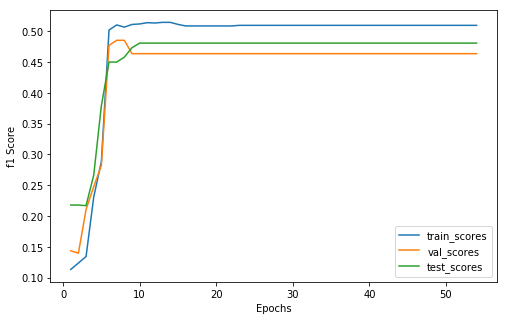

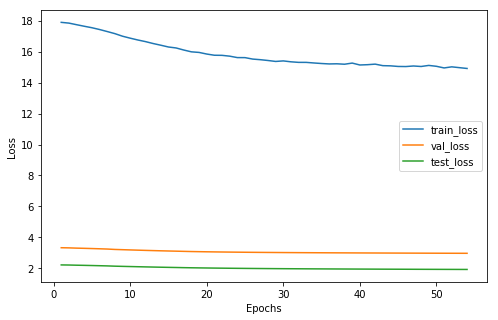

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 54 xxxxxxxxxxxxxx


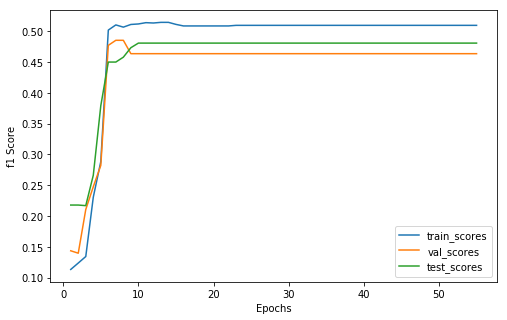

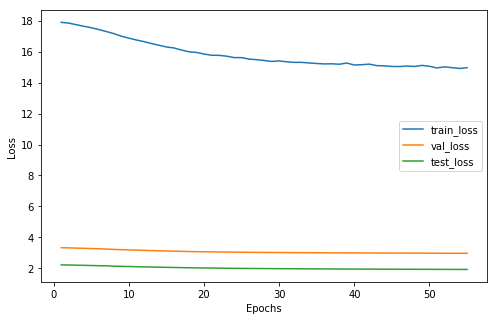

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 55 xxxxxxxxxxxxxx


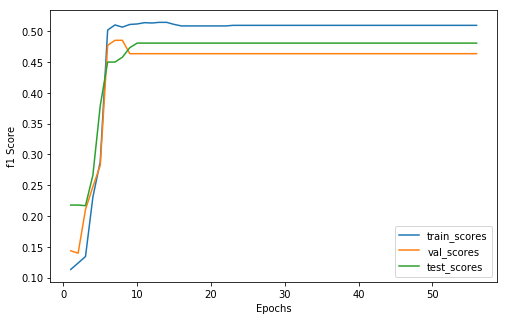

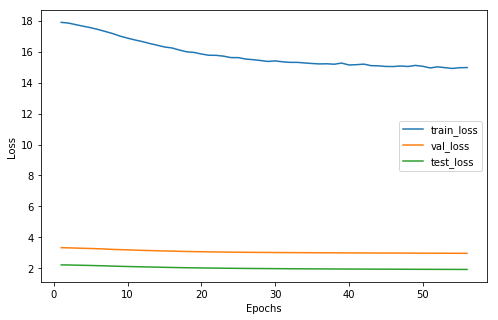

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 56 xxxxxxxxxxxxxx


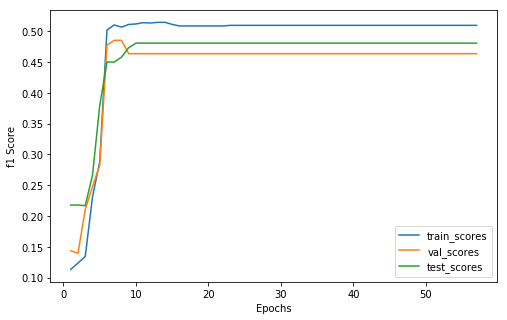

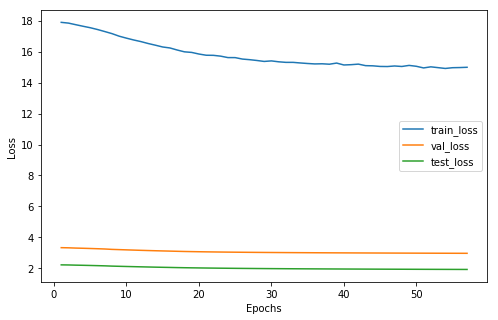

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 57 xxxxxxxxxxxxxx


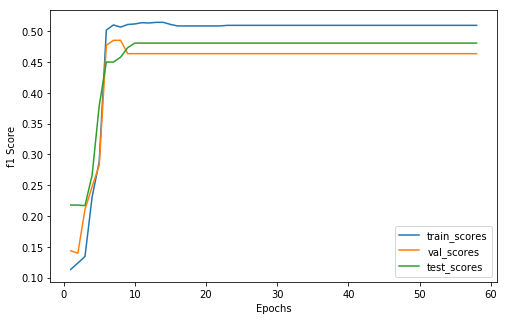

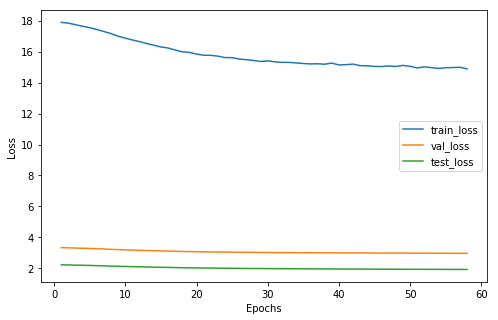

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 58 xxxxxxxxxxxxxx


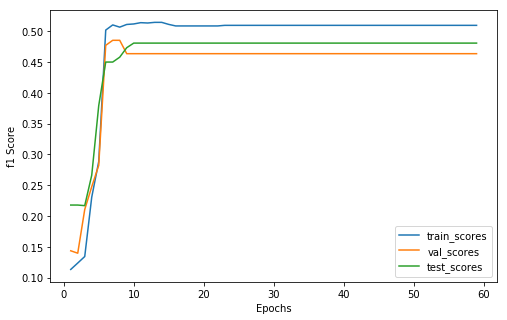

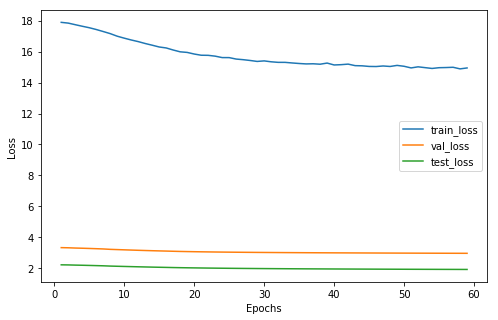

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 59 xxxxxxxxxxxxxx


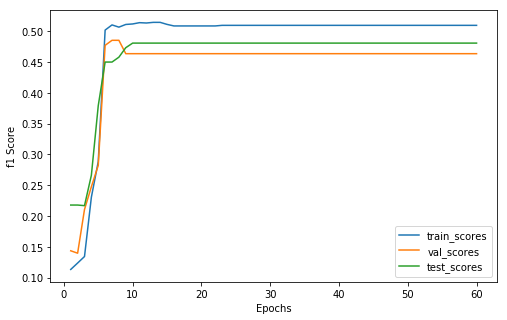

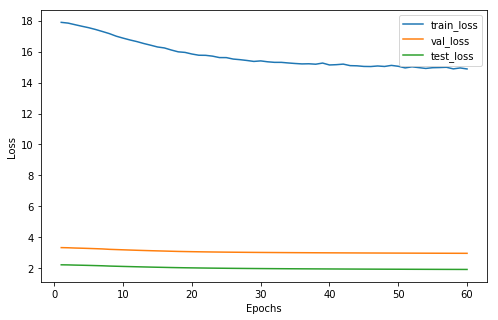

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 60 xxxxxxxxxxxxxx


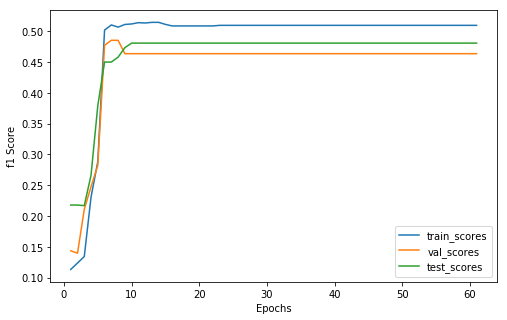

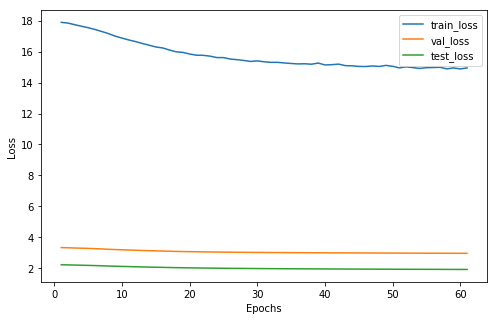

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 61 xxxxxxxxxxxxxx


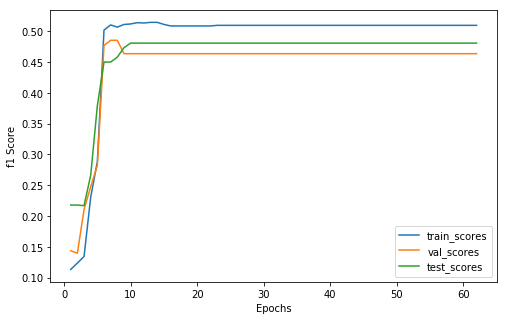

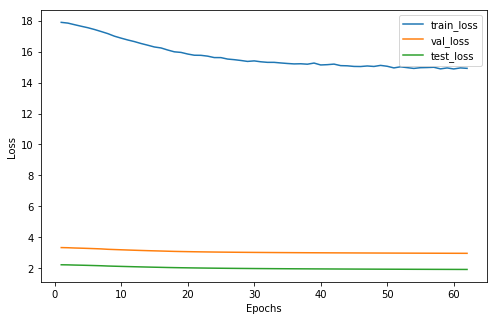

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 62 xxxxxxxxxxxxxx


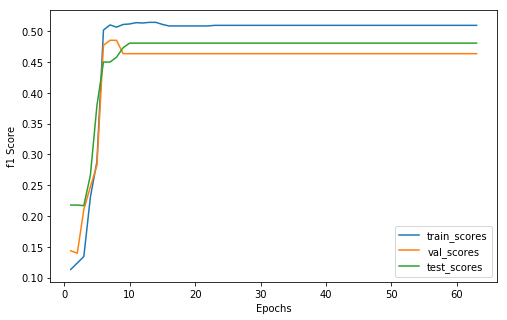

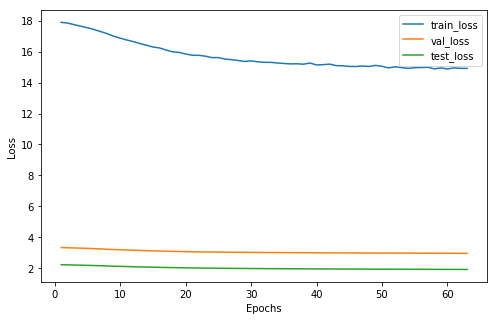

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 63 xxxxxxxxxxxxxx


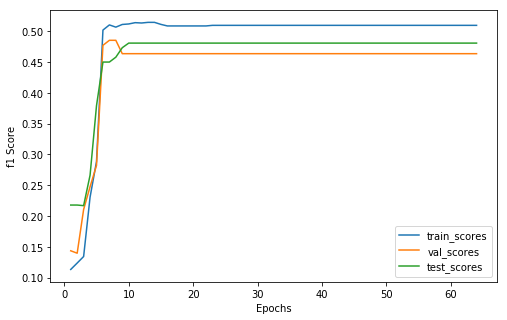

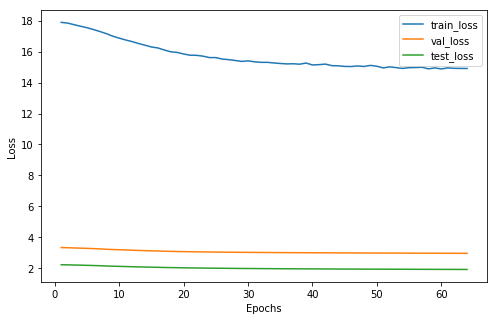

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 64 xxxxxxxxxxxxxx


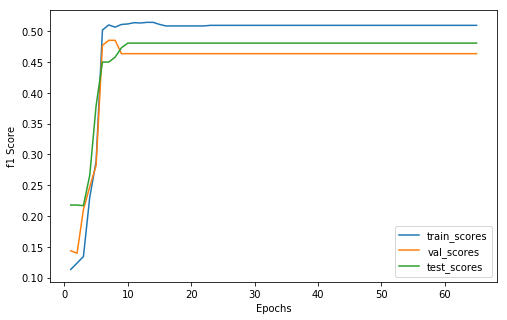

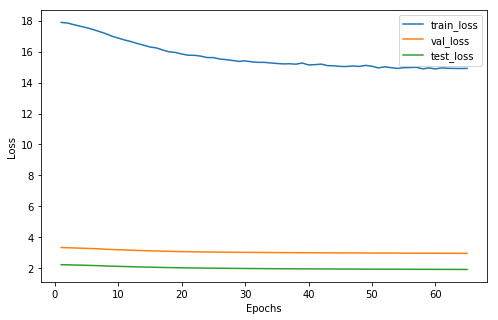

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 65 xxxxxxxxxxxxxx


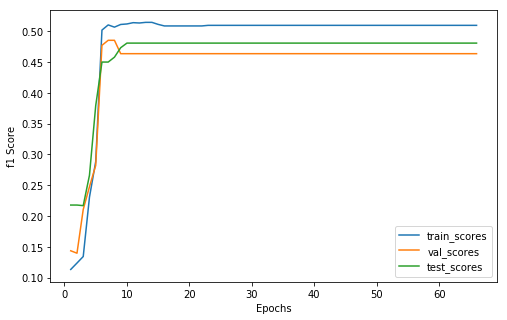

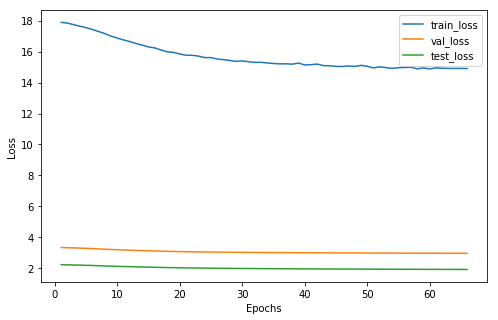

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 66 xxxxxxxxxxxxxx


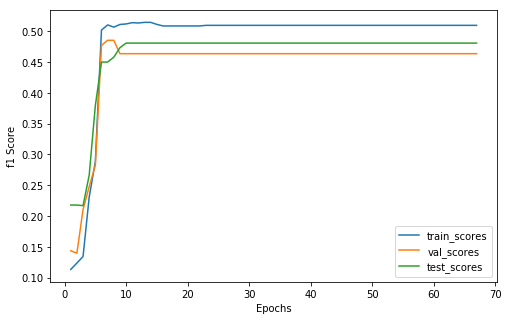

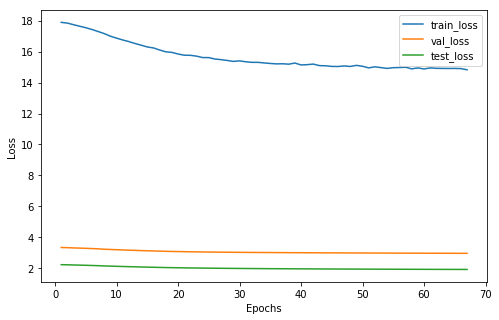

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 67 xxxxxxxxxxxxxx


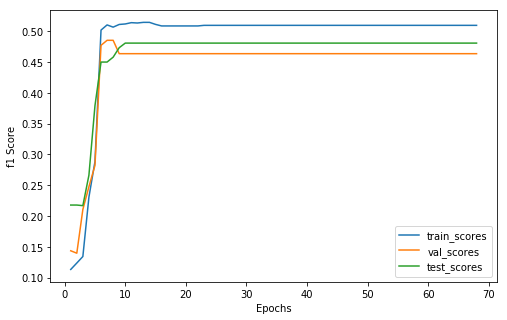

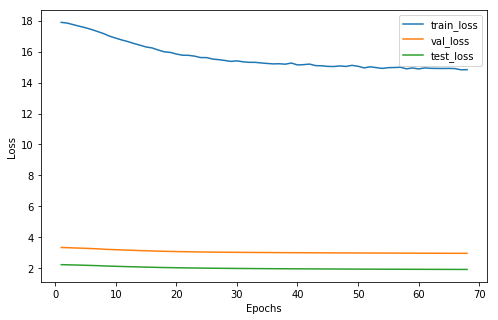

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 68 xxxxxxxxxxxxxx


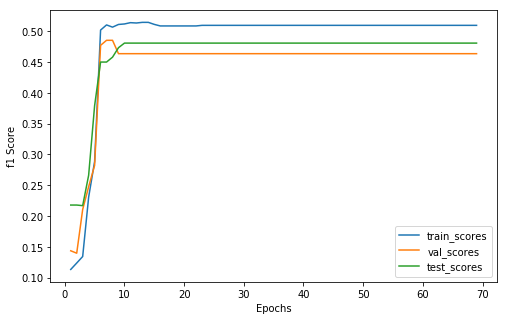

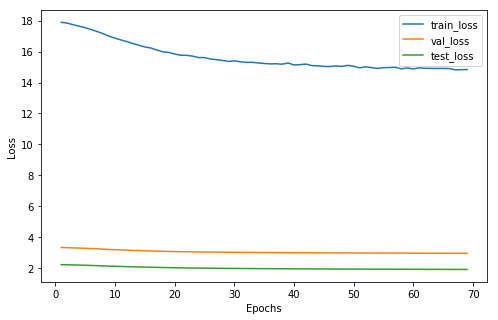

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 69 xxxxxxxxxxxxxx


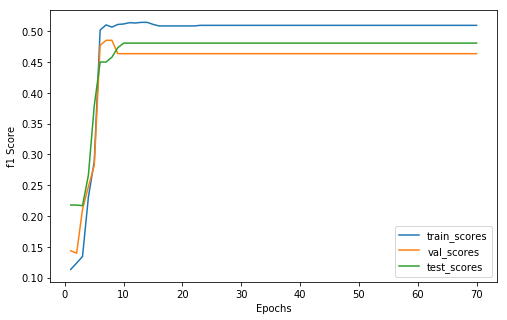

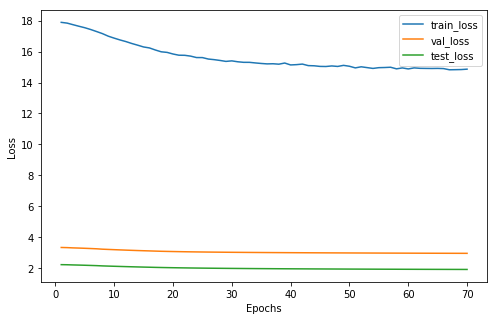

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 70 xxxxxxxxxxxxxx


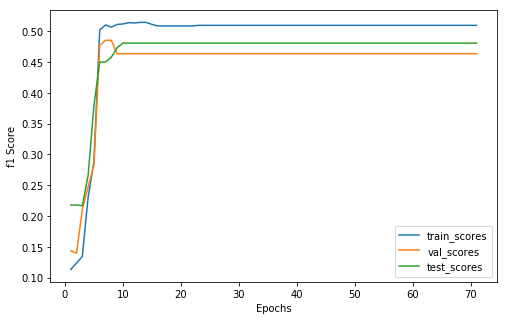

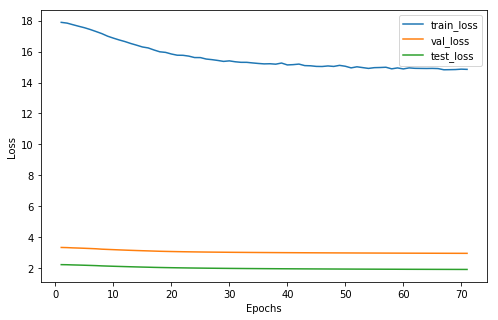

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 71 xxxxxxxxxxxxxx


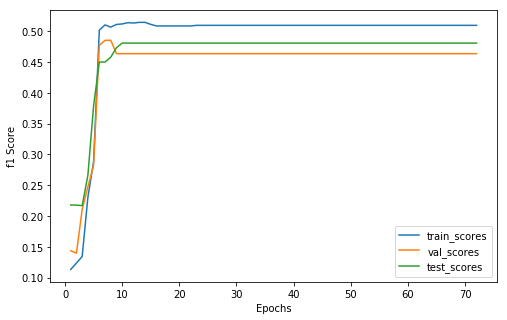

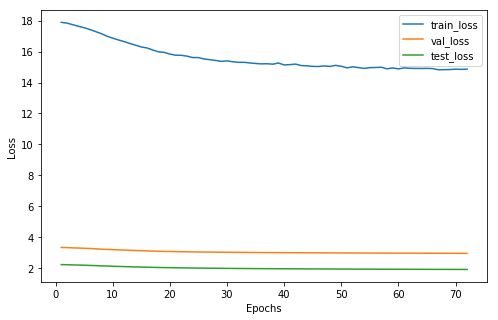

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 72 xxxxxxxxxxxxxx


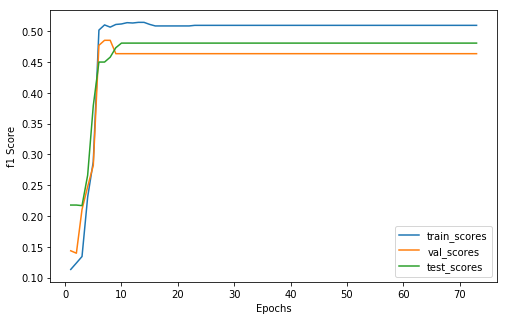

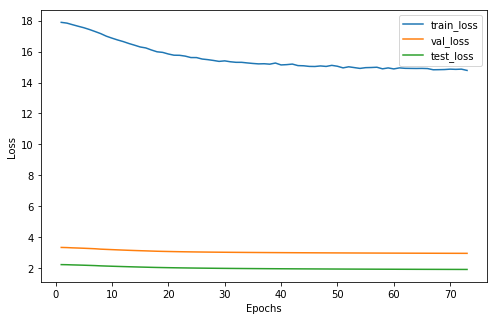

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 73 xxxxxxxxxxxxxx


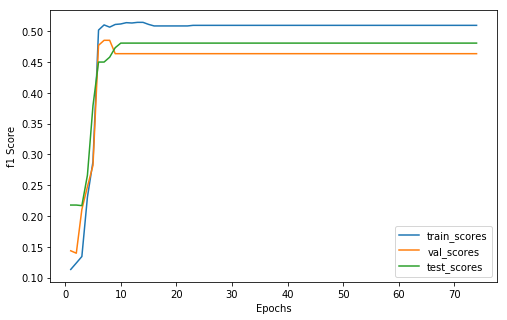

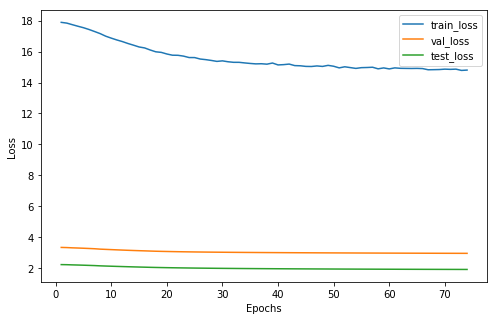

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 74 xxxxxxxxxxxxxx


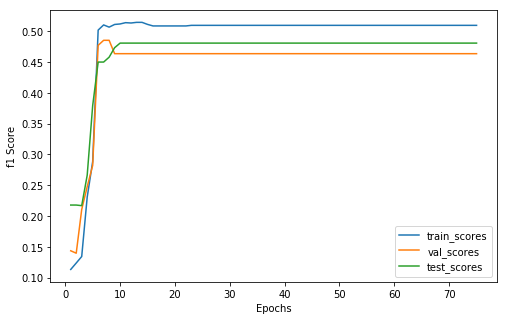

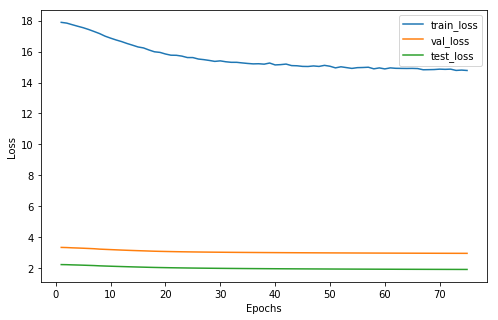

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 75 xxxxxxxxxxxxxx


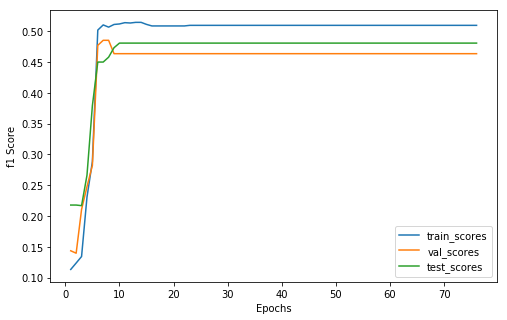

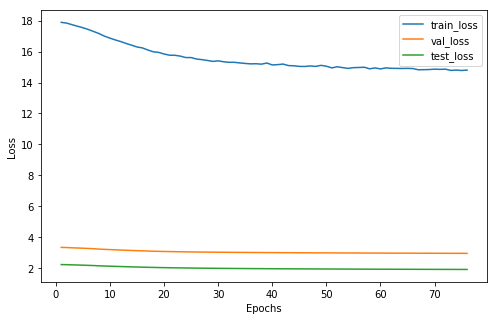

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 76 xxxxxxxxxxxxxx


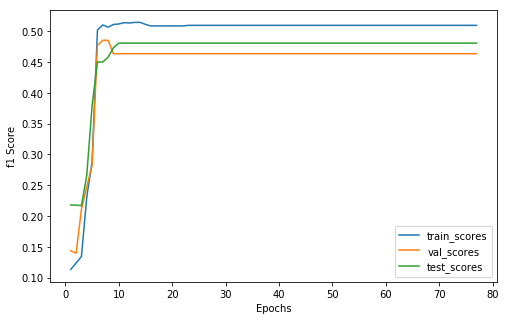

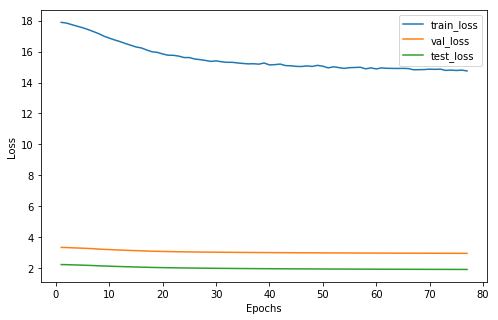

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 77 xxxxxxxxxxxxxx


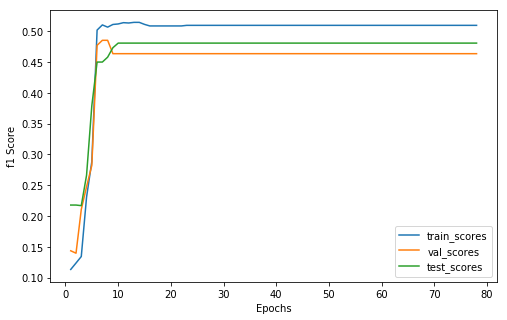

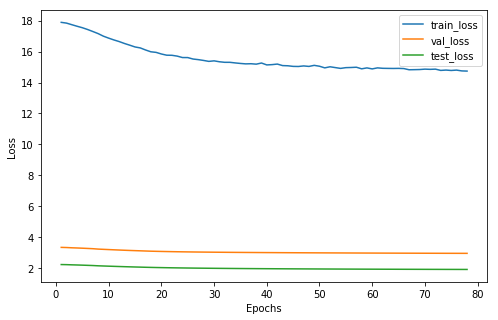

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 78 xxxxxxxxxxxxxx


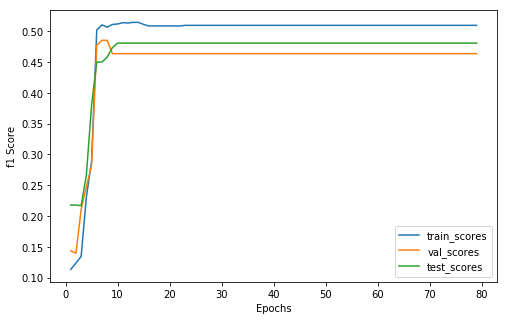

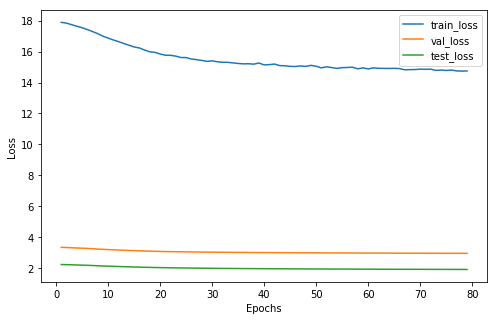

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
xxxxxxxxxxxxxx epoch: 79 xxxxxxxxxxxxxx


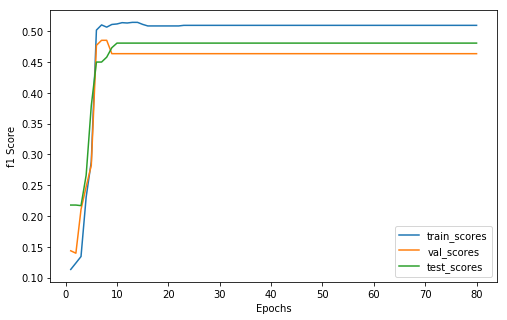

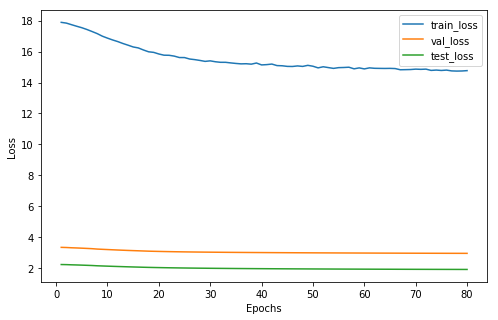

Cofusion Matrix For Val Set: 
-  --  -
0  14  0
0  44  0
0  14  0
-  --  -
X==XX==XX==XX==XX==X
best_test_f1: 0.4807692307692308
best_val_f1: 0.48531920077972707


In [45]:
running_loss = 0.0
best_test_f1 = 0
best_val_f1 = 0
loss_over_epochs, scores_over_epochs = plotting.get_empty_stat_over_n_epoch_dictionaries()
for epoch in range(n_epochs):
    
    train_loss, train_labels, train_preds = eval_network(train_loader, net, criterion, optimizer, training=True)
    val_loss, val_labels, val_preds = eval_network(val_loader, net, criterion, optimizer)
    test_loss, test_labels, test_preds = eval_network(test_loader, net, criterion, optimizer)

    train_scores = metrics.precision_recall_fscore_support(train_labels, train_preds, average='weighted')
    val_scores = metrics.precision_recall_fscore_support(val_labels, val_preds, average='weighted')
    test_scores = metrics.precision_recall_fscore_support(test_labels, test_preds, average='weighted')
    
    scores_over_epochs['train_scores'].append(train_scores)
    scores_over_epochs['val_scores'].append(val_scores)
    scores_over_epochs['test_scores'].append(test_scores)
    
    loss_over_epochs['train_loss'].append(train_loss)
    loss_over_epochs['val_loss'].append(val_loss)
    loss_over_epochs['test_loss'].append(test_loss)
    
    if True:#epoch%5 == 0:
        print("xxxxxxxxxxxxxx epoch: {} xxxxxxxxxxxxxx".format(epoch))
        plotting.plot_score_over_n_epochs(scores_over_epochs, score_type='f1', fig_size=(8,5))
        plotting.plot_loss_over_n_epochs(loss_over_epochs, fig_size=(8, 5))
        print("Cofusion Matrix For Val Set: ")
        print(tabulate( metrics.confusion_matrix(val_labels, val_preds)))
#         print("Predicted Label Distribution:")
#         print(statistics.get_train_test_val_label_counts_from_predictions(train_preds, val_preds, test_preds))

    best_test_f1 = test_scores[2] if best_test_f1 < test_scores[2] else best_test_f1
    best_val_f1 = val_scores[2] if best_val_f1 < val_scores[2] else best_val_f1

print("X==X"*5)
print("best_test_f1: {}".format(best_test_f1))
print("best_val_f1: {}".format(best_val_f1))
    

In [34]:
torch.LongTensor([12,3]).numpy().tolist()


[12, 3]

In [ ]:
torch.Tensor([2222,1]).max()